In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import join
np.random.seed(0)
import random

from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style = 'white' , context = 'notebook' , palette = 'deep')

####

In [41]:
data_path = "data"
train  = pd.read_csv(join(data_path,"train.csv"))
test  = pd.read_csv(join(data_path,"test.csv"))

In [42]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1)

del train

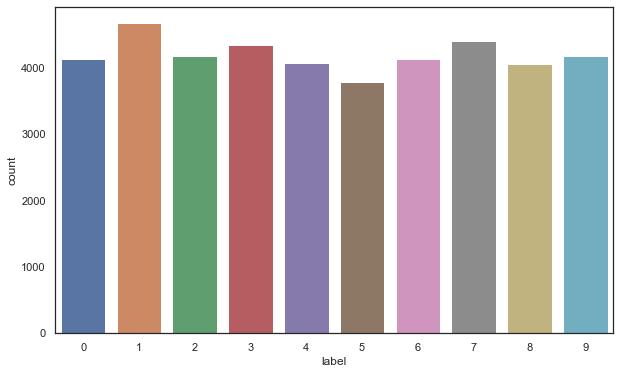

In [43]:
#print(Y_train.value_counts())

rcParams['figure.figsize'] = 10,6
p = sns.countplot(Y_train)

In [44]:
print(Y_train.isna().value_counts())
print(X_train.isna().any().value_counts())

False    42000
Name: label, dtype: int64
False    784
dtype: int64


In [45]:
def process_data(data):
    data = data/255.0
    data = data.values.reshape(-1,28,28,1)
    return data

In [46]:
X_train = process_data(X_train)

In [47]:
Y_train = to_categorical(Y_train,num_classes = 10)

In [48]:
random_seed = 0
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)

In [49]:
def plot_image(size,images):
    if len(images)!= size[0]*size[1]:
        raise Exception("number of images doesn't match the size of plot")
    fig, ax = plt.subplots(size[0],size[1],figsize=(10,10))
    for i in range(size[0]):
        for j in range(size[1]):
            ax[i][j].imshow(images[i*size[1]+j][:,:,0], cmap = "gray_r")

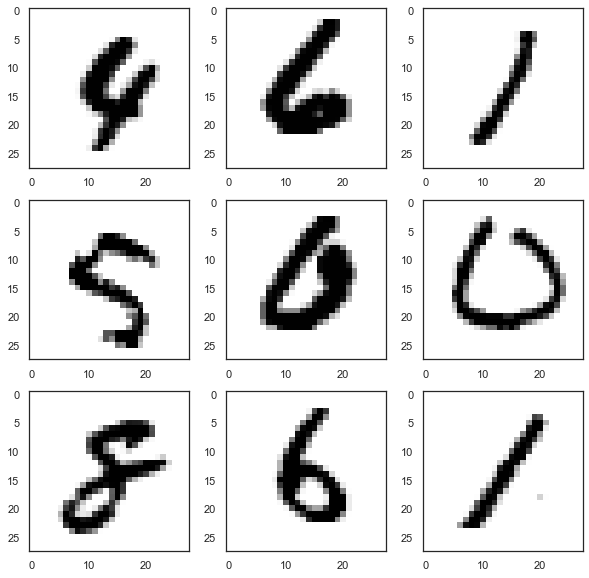

In [50]:
images = random.sample(list(X_train),9)
plot_image((3,3),images)


In [51]:
#CNN

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "same", activation = "relu", input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)       

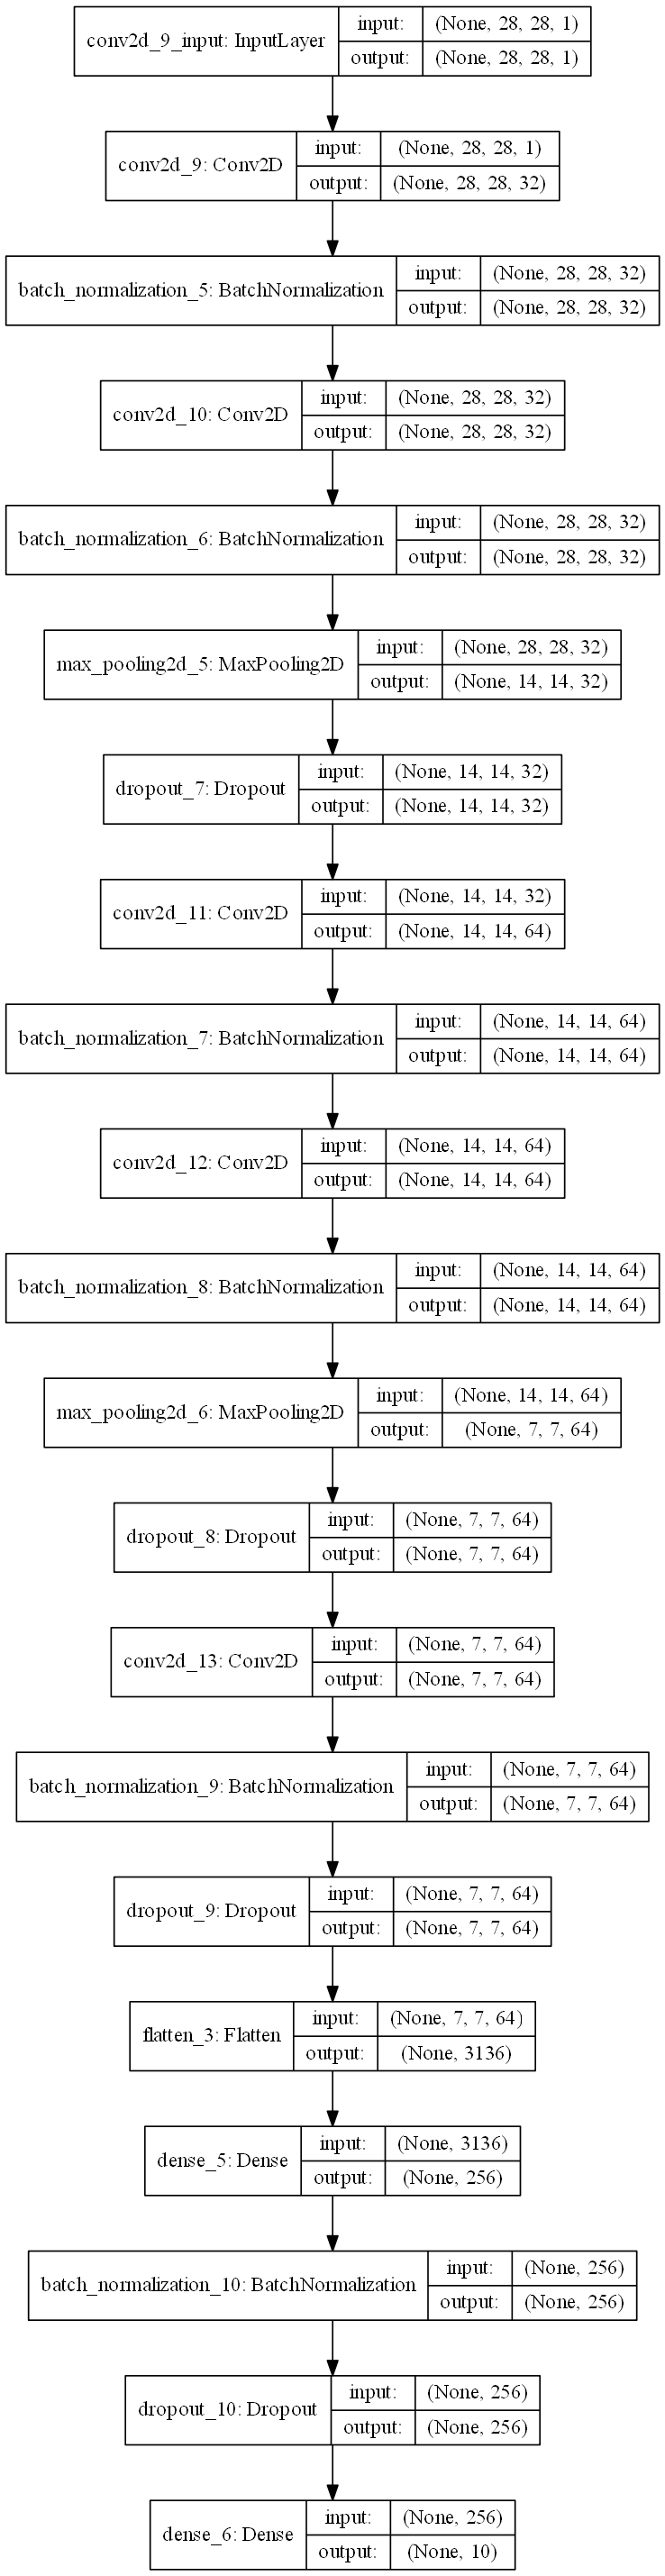

In [52]:
plot_model(model, to_file='temp/model.png', show_shapes=True, show_layer_names=True,dpi = 120)

In [53]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

In [54]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [65]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [66]:
epochs = 1
batch_size = 64

In [67]:
# history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val,Y_val), verbose = 2)

In [68]:
datagen = ImageDataGenerator(featurewise_center = False,
                             samplewise_center = False,
                             featurewise_std_normalization = False,
                             samplewise_std_normalization = False,
                             zca_whitening = False,
                             rotation_range = 10,
                             zoom_range = 0.1,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = False,
                             vertical_flip = False
                            )
datagen.fit(X_train)

In [69]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size), epochs = epochs, validation_data = (X_val,Y_val), verbose = 2, steps_per_epoch = X_train.shape[0]//batch_size, callbacks=[learning_rate_reduction])

Epoch 1/1
 - 162s - loss: 0.0892 - accuracy: 0.9724 - val_loss: 0.0550 - val_accuracy: 0.9837


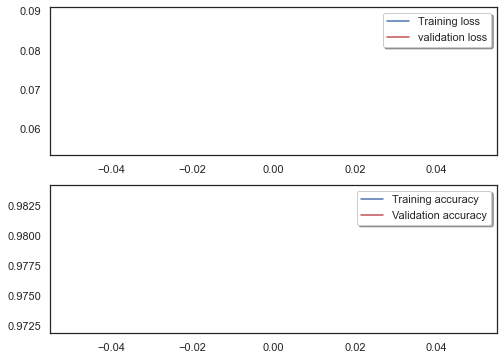

In [70]:
fig, ax = plt.subplots(2,1, figsize=(8, 6))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

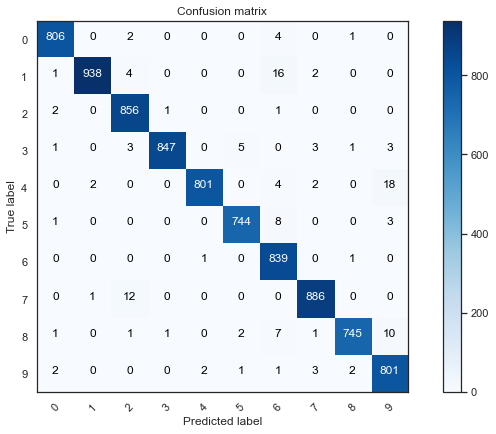

In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_val)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [63]:
test = process_data(test)

In [64]:
results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [39]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv(join("results","keras_cnn_mnist_aug2.csv"),index=False)